## **Giới thiệu về đồ án**

Đồ án này dựa trên cuộc thi ALASKA2 Image Steganalysis trên Kaggle, tập trung vào việc phát triển các phương pháp hiệu quả và đáng tin cậy để phát hiện dữ liệu bí mật được ẩn trong các hình ảnh kỹ thuật số. Trong đồ án này, nhóm em sẽ sử dụng 2 mô hình để thực hiện công việc trên, đó là mô hình ResNet50 và mô hình EfficientNet-B2.

## **Giới thiệu và trình bày chi tiết về bài toán**

Bài toán ở đây là người tham gia phát triển các phương pháp hiệu quả để phát hiện dữ liệu bí mật được ẩn trong hình ảnh. Thay vì giới hạn ở một nguồn dữ liệu duy nhất, các hình ảnh được thu thập từ 50 loại máy ảnh khác nhau và xử lý theo nhiều cách, mô phỏng các điều kiện thực tế. Yêu cầu là xây dựng các thuật toán phát hiện mạnh mẽ với tỷ lệ FPR thấp. Đánh giá được thực hiện bằng AUC có trọng số, ưu tiên các mô hình hoạt động tốt trong việc giảm thiểu cảnh báo sai.

## **Tiền xử lý dữ liệu và trích xuất đặc trưng**

Đầu tiên, lấy bộ dữ liệu ALASKA2 Image Steganalysis có sẵn trên Kaggle và đã được chia thành 5 phần: Cover, JMiPOD, JUNIWARD, UERD, và Test. Sau đó chỉ lấy ra 30000 dữ liệu để sử dụng cho bài toán, vì dữ liệu quá lớn sẽ tốn nhiều tài nguyên hơn để huấn luyện. Số lượng dữ liệu trên được phân bố như sau: 15000 dữ liệu thuộc thư mục Cover, 5000 dữ liệu thuộc JMiPOD, 5000 dữ liệu thuộc JUNIWARD, 5000 dữ liệu thuộc UERD. Gán nhãn cho các ảnh trong thư mục Cover là 0, đại diện cho không có mật mã trong hình, và ở 3 thư mục còn lại gán nhãn 1, đại diện cho hình có chứa mật mã. Cuối cùng là lấy ra 5000 dữ liệu trong thư mục Test để sử dụng cho quá trình dự đoán.

Sau đó, tổng hợp dữ liệu của 4 tập dữ liệu input lại, xáo trộn và chia ra thành 2 phần bao gồm tập train và tập test với tỉ lệ 80:20.

Các bước tiền xử lý dữ liệu được thực hiện như sau:

- Bước 1: Mở hình ảnh bằng thư viện PIL

- Bước 2: Chuyển kênh màu từ RGB sang YCbCr

- Bước 3: Resize hình ảnh về ma trận vuông có kích thước 384 x 384

- Bước 4: Chuẩn hóa các giá trị pixel của hình về đoạn [0, 1] bằng cách chia cho 255.0
0

- Bước 5: Đổi thứ tự kênh từ (H, W, C) sang (C, H, W) để có thể tính toán theo quy ước của thư viện PyTorch.

- Bước 6: Chuẩn hóa từng kênh theo mean và std theo quy ước của ImageNet, mỗi phần tử trong mean và std đại diện cho tham số để chuẩn hóa từng kênh, theo công thức $\frac{T - mean}{std}$ với T là giá trị của kênh.



## **Xây dựng mô hình**
Ở bài tập này, nhóm em sử dụng 2 mô hình là EfficentNet B2 và ResNet50, quá trình xây dựng mô hình như sau:

- Bước 1: Khởi tạo mô hình sử dụng trọng số pre-trained.

- Bước 2: Tùy chỉnh lớp cuối của mô hình cho bài toán phân loại 2 lớp, vì các mô hình này được huấn luyện trên dataset ImageNet, được sử dụng để phân loại 1000 lớp nên chúng ta cần tùy chỉnh lại lớp cuối để phù hợp với bài toán.

- Bước 3: Đóng băng các trọng số của các lớp không phải lớp cuối để không được cập nhật lại trong quá trình lan truyền ngược, từ đó có thể giữ nguyên pre-trained model mà vẫn có thể sử dụng cho bài toán phân loại nhị phân của chúng ta.

In [ ]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F

## Tải dataset và hàm đọc data từ các thư mục

In [3]:
base_path = '../input/alaska2-image-steganalysis'

def read_images_path(dir_name, label):
    folder_path = os.path.join(base_path, dir_name)  # Đường dẫn đến thư mục
    return [[os.path.join(folder_path, filename), label] for filename in os.listdir(folder_path)]

## Đọc data từ các thư mục chứa data input, sau đó phân bố dữ liệu sao cho phù hợp với các lớp

In [4]:
sample_size = 15000

cover_img = read_images_path('Cover', 0)[:sample_size]
jmipod_img = read_images_path('JMiPOD', 1)[:(sample_size//3)]
juniward_img = read_images_path('JUNIWARD', 1)[:(sample_size//3)]
uerd_img = read_images_path('UERD', 1)[:(sample_size//3)]

test_img = read_images_path('Test', 0.7)

data = cover_img + jmipod_img + juniward_img + uerd_img
df = pd.DataFrame(data=data, columns=['path', 'label'])

test = pd.DataFrame(data=test_img, columns=['path', 'label'])

## Chia dữ liệu thành tập train và tập val

In [5]:
def split_dataframe(df, ratio):
    # Xáo trộn dữ liệu để đảm bảo tính ngẫu nhiên
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Chia dữ liệu thành hai phần
    split_point = int(len(df) * ratio)
    return df.iloc[:split_point], df.iloc[split_point:]

train, val = split_dataframe(df, 0.8)

In [6]:
train

,path,label
0,../input/alaska2-image-steganalysis/JMiPOD/357...,1
1,../input/alaska2-image-steganalysis/Cover/6485...,0
2,../input/alaska2-image-steganalysis/Cover/4958...,0
3,../input/alaska2-image-steganalysis/Cover/7276...,0
4,../input/alaska2-image-steganalysis/Cover/1449...,0
...,...,...
23995,../input/alaska2-image-steganalysis/Cover/2653...,0
23996,../input/alaska2-image-steganalysis/JMiPOD/289...,1
23997,../input/alaska2-image-steganalysis/UERD/41804...,1
23998,../input/alaska2-image-steganalysis/JMiPOD/130...,1


## Hàm tiền xử lý dữ liệu

- Bước 1: Mở hình ảnh bằng thư viện PIL

- Bước 2: Chuyển kênh màu từ RGB sang YCbCr

- Bước 3: Resize hình ảnh về ma trận vuông có kích thước 384 x 384

- Bước 4: Chuẩn hóa các giá trị pixel của hình về đoạn [0, 1] bằng cách chia cho 255.0
0

- Bước 5: Đổi thứ tự kênh từ (H, W, C) sang (C, H, W) để có thể tính toán theo quy ước của thư viện PyTorch.

- Bước 6: Chuẩn hóa từng kênh theo mean và std theo quy ước của ImageNet, mỗi phần tử trong mean và std đại diện cho tham số để chuẩn hóa từng kênh, theo công thức $\frac{T - mean}{std}$ với T là giá trị của kênh.

In [7]:
from PIL import Image
def preprocess_image(image_path, size=(384, 384), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    
    # Bước 1: Tải hình ảnh bằng PIL
    img = Image.open(image_path)
    
    # Bước 2: Chuyển đổi không gian màu sang YCbCr
    img = img.convert("YCbCr")
    
    # Bước 3: Resize hình ảnh về kích thước cố định
    img = img.resize(size)
    
    # Bước 4: Chuyển đổi thành numpy array và chuẩn hóa giá trị pixel về [0, 1]
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    # Đổi thứ tự kênh từ (H, W, C) sang (C, H, W)
    img_array = np.transpose(img_array, (2, 0, 1))
    
    # Chuyển thành tensor PyTorch
    img_tensor = torch.tensor(img_array)
    
    # Chuẩn hóa từng kênh bằng mean và std
    for t, m, s in zip(img_tensor, mean, std):
        t.sub_(m).div_(s)
    
    return img_tensor

def load_image(path):
    img = preprocess_image(path)
    return img


## Tải model ResNet50 từ PyTorch

Nếu có nhân cuda thì sử dụng GPU, nếu không thì sử dụng CPU cho quá trình train

- Bước 1: Khởi tạo mô hình sử dụng trọng số pre-trained.

- Bước 2: Tùy chỉnh lớp cuối của mô hình cho bài toán phân loại 2 lớp, vì các mô hình này được huấn luyện trên dataset ImageNet, được sử dụng để phân loại 1000 lớp nên chúng ta cần tùy chỉnh lại lớp cuối để phù hợp với bài toán.

- Bước 3: Đóng băng các trọng số của các lớp không phải lớp cuối để không được cập nhật lại trong quá trình lan truyền ngược, từ đó có thể giữ nguyên pre-trained model mà vẫn có thể sử dụng cho bài toán phân loại nhị phân của chúng ta.

- Bước 4: Đưa mô hình lên thiết bị để sử dụng

In [8]:
from torchvision.models import resnet50
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

# Khởi tạo mô hình ResNet50 với trọng số pre-trained
resnet_model = resnet50(pretrained=True)

# Tùy chỉnh lớp cuối cùng của mô hình
num_classes = 2  # Số lượng lớp trong bài toán (phân loại nhị phân)
resnet_model.fc = torch.nn.Sequential(
    torch.nn.Linear(resnet_model.fc.in_features, num_classes)
)

# Đóng băng các tham số trong phần backbone
for name, param in resnet_model.named_parameters():
    if "fc" not in name:  # Chỉ giữ nguyên các lớp không phải classifier
        param.requires_grad = False

# Đưa mô hình lên thiết bị
resnet_model.to(device)

# Chuyển sang chế độ đánh giá
resnet_model.eval()

print("ResNet50 model has been customized and is ready!")


CUDA is available. Using GPU.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s] 


ResNet50 model has been customized and is ready!


## Đọc và load data để sử dụng cho quá trình train

- Tạo class cho các dataset cần đọc, class này sẽ chứa thông tin về đường dẫn và nhãn của ảnh, sau đó là tiền xử lý ảnh.

- Khởi tạo các tham số cần thiết cho quá trình train.

- Sử dụng optimizer Adam cho model, với learning rate = 0.0001

- Tạo iterator để tải dữ liệu cho quá trình train bằng DataLoader của PyTorch


In [9]:
from torch.utils.data import Dataset, DataLoader

class reader(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Lấy đường dẫn ảnh và nhãn
        img_path = self.image_paths[index]
        label = self.labels[index]

        # Sử dụng hàm preprocess_image
        image = preprocess_image(img_path)

        return image, label

BATCHSIZE = 256
EPOCHS = 10
LR = 0.0001
WEIGHT_DECAY = 0
WEIGHTS = torch.tensor([4, 1], dtype=torch.float32).to(device)

optimizer = torch.optim.Adam(resnet_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Tạo dataset cho train và validation
train_dataset = reader(train['path'].tolist(), train['label'].tolist())
val_dataset = reader(val['path'].tolist(), val['label'].tolist())

# Tạo DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=2, pin_memory=True)


## Tính toán metric Weighted AUC

- Bước 1: Tính False Positive Rate, True Positive Rate bằng hàm roc_curve

- Bước 2: Chia vùng và tính AUC từng vùng, theo yêu cầu đề bài thì ta có 2 vùng ROC gồm:

    - Vùng 1: TPR từ 0.0 đến 0.4

    - Vùng 2: TPR từ 0.4 đến 1.0

    - Sau đó, chọn ra mask là các điểm có TPR thuộc từng vùng đang cần xem xét

    - Tính diện tích dưới đường cong, nghĩa là giá trị AUC bằng nguyên tắc hình thang để tính gần đúng giá trị diện tích đó 

- Bước 3: Tính Weighted AUC theo công thức 
$$Weighted\_AUC = \frac{\sum_{i=1}^{n-1} (AUC_i \cdot w_i)}{\sum_{i=1}^{n-1} w_i}$$

- Hàm calculate_metrics() thực hiện tính toán các metric Weighted AUC và Accuracy dựa trên label của hình ảnh và xác suất, kết quả dự đoán được của mô hình  


In [10]:
from sklearn.metrics import accuracy_score, roc_curve
def weighted_auc(y_true, y_score, tpr_thresholds=[0.0, 0.4, 1.0], weights=[2, 1]):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    
    # Tính AUC cho từng vùng
    auc_scores = []
    for i in range(len(tpr_thresholds) - 1):
        start = tpr_thresholds[i]
        end = tpr_thresholds[i+1]
        
        # Lọc các điểm trong vùng hiện tại
        mask = (tpr >= start) & (tpr < end)
        auc_scores.append(np.trapz(tpr[mask], fpr[mask]))
    
    # Tính AUC có trọng số
    weighted_auc = np.sum(np.multiply(auc_scores, weights)) / np.sum(weights)
    
    return weighted_auc

def calculate_metrics(model, dataloader, device='cpu'):
    model.to(device).eval()
    labels, probs, preds = [], [], []

    with torch.no_grad():
        for images, batch_labels in dataloader:
            outputs = model(images.to(device))
            batch_probs = F.softmax(outputs, dim=1)[:, 1]
            batch_preds = torch.argmax(outputs, dim=1)

            labels.extend(batch_labels.cpu().numpy())
            probs.extend(batch_probs.cpu().numpy())
            preds.extend(batch_preds.cpu().numpy())

    labels = np.array(labels)
    probs = np.array(probs)
    preds = np.array(preds)

    return {
        'Weighted AUC': weighted_auc(labels, probs),
        'Accuracy': accuracy_score(labels, preds)
    }

## Tiến hành huấn luyện mô hình

- Huấn luyện mô hình với hàm lỗi sử dụng Cross Entropy

- Quá trình Validation để tính toán các metric, sau cùng là load model tốt nhất và lưu model lại dưới dạng file .pth, file mô hình của PyTorch

In [11]:
from tqdm import tqdm
train_losses = []  
accuracies = []  
weighted_aucs = []  
best_auc = 0

for epoch in range(EPOCHS):
    print('EPOCH: ',epoch+1)
    
    # Training phase
    resnet_model.train()
    train_loss = 0
    for images, labels in tqdm(train_dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        loss = F.cross_entropy(resnet_model(images), labels, weight=WEIGHTS)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print('Average Training Loss: ',avg_train_loss)
    
    # Validation phase
    metrics = calculate_metrics(resnet_model, val_dataloader, device)
    acc = metrics['Accuracy']
    current_auc = metrics['Weighted AUC']
    
    accuracies.append(acc)
    weighted_aucs.append(current_auc)
                        
    print('Accuracy: ', acc)
    print('Weighted AUC: ', current_auc)

    
    if current_auc > best_auc:
        best_auc = current_auc
        torch.save(resnet_model.state_dict(), 'best_model.pth')
        print('New best model saved with Weighted AUC: ',best_auc)
    
    print()

# Load best model
resnet_model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded!")

EPOCH:  1


Training: 100%|██████████| 94/94 [05:18<00:00,  3.39s/it]

Average Training Loss:  0.5157322959696993


Accuracy:  0.497
Weighted AUC:  0.19449666854673434
New best model saved with Weighted AUC:  0.19449666854673434

EPOCH:  2


Training: 100%|██████████| 94/94 [04:08<00:00,  2.64s/it]

Average Training Loss:  0.5063681504193772


Accuracy:  0.497
Weighted AUC:  0.1940766163878196

EPOCH:  3


Training: 100%|██████████| 94/94 [04:07<00:00,  2.63s/it]

Average Training Loss:  0.5048897542217945


Accuracy:  0.497
Weighted AUC:  0.1957971042513086
New best model saved with Weighted AUC:  0.1957971042513086

EPOCH:  4


Training: 100%|██████████| 94/94 [04:08<00:00,  2.64s/it]

Average Training Loss:  0.5035629469029447


Accuracy:  0.497
Weighted AUC:  0.19630865970434197
New best model saved with Weighted AUC:  0.19630865970434197

EPOCH:  5


Training: 100%|██████████| 94/94 [04:07<00:00,  2.63s/it]

Average Training Loss:  0.5026320742165789


Accuracy:  0.497
Weighted AUC:  0.19730249177859294
New best model saved with Weighted AUC:  0.19730249177859294

EPOCH:  6


Training: 100%|██████████| 94/94 [04:05<00:00,  2.61s/it]

Average Training Loss:  0.5019340756091666


Accuracy:  0.497
Weighted AUC:  0.195340680412643

EPOCH:  7


Training: 100%|██████████| 94/94 [04:05<00:00,  2.61s/it]

Average Training Loss:  0.5020134880187663


Accuracy:  0.497
Weighted AUC:  0.1953734778896485

EPOCH:  8


Training: 100%|██████████| 94/94 [04:06<00:00,  2.62s/it]

Average Training Loss:  0.5011948163205004


Accuracy:  0.497
Weighted AUC:  0.19457433800950166

EPOCH:  9


Training: 100%|██████████| 94/94 [04:08<00:00,  2.64s/it]

Average Training Loss:  0.5006766293911223


Accuracy:  0.497
Weighted AUC:  0.1941143399680907

EPOCH:  10


Training: 100%|██████████| 94/94 [04:03<00:00,  2.59s/it]

Average Training Loss:  0.4999421032819342


Accuracy:  0.497
Weighted AUC:  0.1934137777108124

EPOCH:  11


Training: 100%|██████████| 94/94 [04:04<00:00,  2.60s/it]

Average Training Loss:  0.500105139105878


Accuracy:  0.497
Weighted AUC:  0.19420004675723881

EPOCH:  12


Training: 100%|██████████| 94/94 [04:09<00:00,  2.65s/it]

Average Training Loss:  0.4995946662223085


Accuracy:  0.497
Weighted AUC:  0.19414980420776629

EPOCH:  13


Training: 100%|██████████| 94/94 [04:04<00:00,  2.60s/it]

Average Training Loss:  0.5002797017706201


Accuracy:  0.497
Weighted AUC:  0.19401887356833733

EPOCH:  14


Training: 100%|██████████| 94/94 [04:04<00:00,  2.60s/it]

Average Training Loss:  0.4993040875551548


Accuracy:  0.497
Weighted AUC:  0.1931318416351878

EPOCH:  15


Training: 100%|██████████| 94/94 [04:02<00:00,  2.58s/it]

Average Training Loss:  0.49958347132865416


Accuracy:  0.497
Weighted AUC:  0.19285390570356828

EPOCH:  16


Training: 100%|██████████| 94/94 [04:04<00:00,  2.60s/it]

Average Training Loss:  0.4992523694292028


Accuracy:  0.497
Weighted AUC:  0.19300846682332415

EPOCH:  17


Training: 100%|██████████| 94/94 [04:04<00:00,  2.61s/it]

Average Training Loss:  0.4993714541196823


Accuracy:  0.497
Weighted AUC:  0.19295231665376988

EPOCH:  18


Training: 100%|██████████| 94/94 [04:05<00:00,  2.61s/it]

Average Training Loss:  0.49930908768735033


Accuracy:  0.497
Weighted AUC:  0.19286962849181088

EPOCH:  19


Training: 100%|██████████| 94/94 [04:03<00:00,  2.59s/it]

Average Training Loss:  0.49812323806133674


Accuracy:  0.497
Weighted AUC:  0.19184373970796278

EPOCH:  20


Training: 100%|██████████| 94/94 [04:05<00:00,  2.61s/it]

Average Training Loss:  0.4987850135311167


Accuracy:  0.497
Weighted AUC:  0.19334621972316926

Best model loaded!


<ipython-input-11-f89a33c23439>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('best_model.pth'))


## Vẽ biểu đồ cho 3 thang điểm bao gồm Loss, Accuracy và Weighted AUC

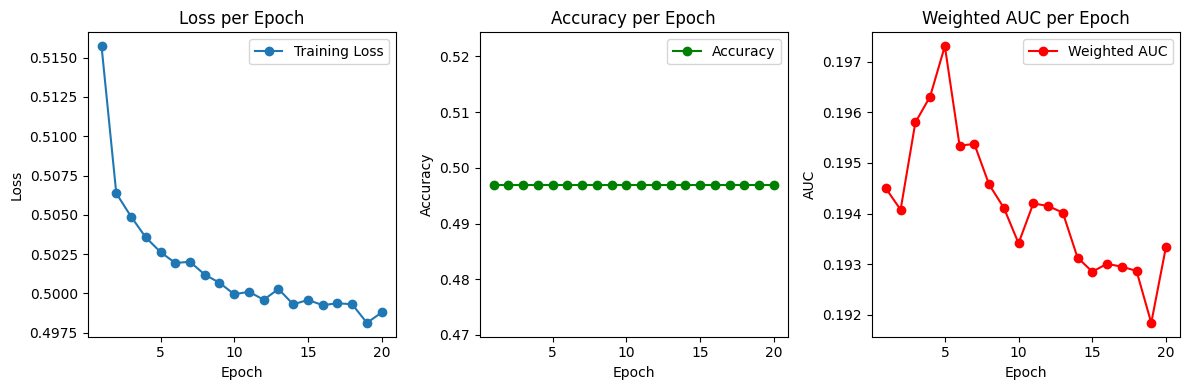

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, EPOCHS+1), accuracies, marker='o', label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Plot Weighted AUC
plt.subplot(1, 3, 3)
plt.plot(range(1, EPOCHS+1), weighted_aucs, marker='o', label='Weighted AUC', color='red')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Weighted AUC per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Tiến hành dự đoán

- Hàm predict đưa ra dự đoán cho hình ảnh, output là xác suất hình ảnh đó có mật mã hay không.

- Sắp xếp lại tên của hình ảnh theo thứ tự tăng dần, sau đó lưu vào file submission.csv

In [13]:
def predict(model, test_dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in test_dataloader:
            images = images.to(device)
            outputs = model(images)
            scores = F.softmax(outputs, dim=1)[:, 1]  # Probability of being a stego image
            predictions.extend(scores.cpu().numpy())

    return predictions


test_dataset = reader(test['path'].tolist(), test['label'].tolist())

test_dataloader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Predicting...")
test_predictions = predict(resnet_model, test_dataloader, device)
print("Finish.")

test_image_ids = [os.path.basename(path) for path in test_dataloader.dataset.image_paths]
submission_df = pd.DataFrame({
    'Id': test_image_ids,
    'Label': test_predictions
})

submission_df['Id'] = submission_df['Id'].str.replace('.jpg', '').astype(int)
submission_df = submission_df.sort_values(by='Id')
submission_df['Id'] = submission_df['Id'].astype(str).str.zfill(4) + '.jpg'

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")
submission_df


Predicting...
Finish.
Submission file created: submission.csv


,Id,Label
4946,0001.jpg,0.133308
1370,0002.jpg,0.238156
1444,0003.jpg,0.173673
3709,0004.jpg,0.188246
765,0005.jpg,0.199053
...,...,...
2823,4996.jpg,0.224104
3011,4997.jpg,0.166668
4905,4998.jpg,0.210832
2644,4999.jpg,0.217430


## Nhận xét

- Dựa vào các biểu đồ ở trên, ta thấy được trong quá trình train, độ mất mát giảm liên tục, trong khi độ chính xác giữ nguyên ở mức 0.497 và Weighted AUC biến động nhiều. Tuy nhiên, đối với các giá trị của các thang điểm thì ta thấy mô hình đang thật sự không tốt vì loss tuy có giảm nhưng vẫn còn rất cao, độ chính xác ở mức 0.5 và đặc biệt là Weighted AUC rất thấp, xung quanh 0.195.

- Sau khi dự đoán thì kết quả đưa ra khá thấp, hình ảnh nào cũng có xác suất chứa mật mã thấp, quanh mức 0.23, chứng tỏ mô hình chưa làm tốt được trong việc phát hiện mật mã.

=> Do đó, mô hình ResNet50 không tốt cho bài toán này 